### Import required libraries

In [2]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
import re

c:\users\chesh\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\users\chesh\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Method 1

Generate the summary in the source language and then use translation tools to translate it into another given language

## Part 1 : Summarization

### Read the data

In [34]:
df = pd.read_csv("tennis_articles_v4.csv")

### Inspect the data

In [6]:
df.head()

,article_id,article_text,source
0,1,Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,"BASEL, Switzerland (AP), Roger Federer advance...",http://www.tennis.com/pro-game/2018/10/copil-s...
2,3,Roger Federer has revealed that organisers of ...,https://scroll.in/field/899938/tennis-roger-fe...
3,4,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...


In [7]:
df['article_text'][0]

"Maria Sharapova has basically no friends as tennis players on the WTA Tour. The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much. I think everyone knows this is my job here. When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match. I'm a pretty competitive girl. I say my hellos, but I'm not sending any players flowers as well. Uhm, I'm not really friendly or close to many players. I have not a lot of friends away from the courts.' When she said she is not really close to a lot of players, is that something strategic that she is doing? Is it different on the men's tour than the women's tour? 'No, not at all. I think just because you're in the same 

### Split text into sentences

In [37]:
from nltk.tokenize import sent_tokenize
sentences_m1 = []
for s in df['article_text']:
    sentences_m1.append(sent_tokenize(s))

sentences_m1 = [y for x in sentences_m1 for y in x] # flatten list

In [38]:
sentences_m1[:5]

['Maria Sharapova has basically no friends as tennis players on the WTA Tour.',
 "The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much.",
 'I think everyone knows this is my job here.',
 "When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match.",
 "I'm a pretty competitive girl."]

### GloVe Word Embeddings

In [14]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [15]:
len(word_embeddings)

400000

### Text Preprocessing

In [16]:
# remove punctuations, numbers and special characters
clean_sentences_m1 = pd.Series(sentences_m1).str.replace("[^a-zA-Z]", " ")

# make alphabets lowercase
clean_sentences_m1 = [s.lower() for s in clean_sentences_m1]

In [17]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [19]:
# remove stopwords from the sentences
clean_sentences_m1 = [remove_stopwords(r.split()) for r in clean_sentences_m1]

### Vector representation of sentences

In [20]:
sentence_vectors_m1 = []
for i in clean_sentences_m1:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    sentence_vectors_m1.append(v)

### Similarity matrix preparation

https://arxiv.org/pdf/1602.03606.pdf

In [21]:
# similarity matrices
sim_mat_m1_1 = np.zeros([len(sentences_m1), len(sentences_m1)])
sim_mat_m1_2 = np.zeros([len(sentences_m1), len(sentences_m1)])
sim_mat_m1_3 = np.zeros([len(sentences_m1), len(sentences_m1)])
sim_mat_m1_4 = np.zeros([len(sentences_m1), len(sentences_m1)])

In [22]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_kernels, manhattan_distances, euclidean_distances

#### 1. Cosine Similarity
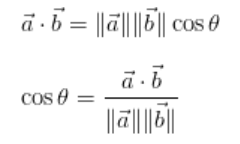

In [23]:
for i in range(len(sentences_m1)):
    for j in range(len(sentences_m1)):
        if i != j:
            sim_mat_m1_1[i][j] = cosine_similarity(sentence_vectors_m1[i].reshape(1,100), sentence_vectors_m1[j].reshape(1,100))[0,0]

#### 2. Manhattan Distance
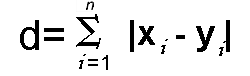

In [24]:
for i in range(len(sentences_m1)):
    for j in range(len(sentences_m1)):
        if i != j:
            sim_mat_m1_2[i][j] = manhattan_distances(sentence_vectors_m1[i].reshape(1,100), sentence_vectors_m1[j].reshape(1,100))[0,0]

#### 3. Euclidean Distance
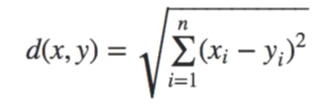

In [25]:
for i in range(len(sentences_m1)):
    for j in range(len(sentences_m1)):
        if i != j:
            sim_mat_m1_3[i][j] = euclidean_distances(sentence_vectors_m1[i].reshape(1,100), sentence_vectors_m1[j].reshape(1,100))[0,0]

#### 4. Pairwise Kernels
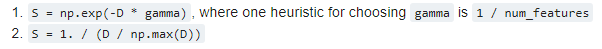

In [26]:
for i in range(len(sentences_m1)):
    for j in range(len(sentences_m1)):
        if i != j:
            sim_mat_m1_4[i][j] = pairwise_kernels(sentence_vectors_m1[i].reshape(1,100), sentence_vectors_m1[j].reshape(1,100))[0,0]

### Applying PageRank Algorithm

In [27]:
import networkx as nx

#### 1. Cosine Similarity

In [28]:
nx_graph_1 = nx.from_numpy_array(sim_mat_m1_1)
scores_m1_1 = nx.pagerank(nx_graph_1)

#### 2. Manhattan Distance

In [29]:
nx_graph_2 = nx.from_numpy_array(sim_mat_m1_2)
scores_m1_2 = nx.pagerank(nx_graph_2)

#### 3. Euclidean Distance

In [30]:
nx_graph_3 = nx.from_numpy_array(sim_mat_m1_3)
scores_m1_3 = nx.pagerank(nx_graph_3)

#### 4. Pairwise Kernels

In [31]:
nx_graph_4 = nx.from_numpy_array(sim_mat_m1_4)
scores_m1_4 = nx.pagerank(nx_graph_4)

### Summary Extraction

#### 1. Cosine Similarity

In [41]:
ranked_sentences_m1_1 = sorted(((scores_m1_1[i],s) for i,s in enumerate(sentences_m1)), reverse=True)

test = []
# Extract top 10 sentences as the summary
for i in range(10):
    test.append(ranked_sentences_m1_1[i][1])

In [44]:
tt = []
for t in test:
    tt.append(word_tokenize(t))

In [46]:
tt = [y for x in tt for y in x] # flatten list

In [47]:
tt

['When',
 'I',
 "'m",
 'on',
 'the',
 'courts',
 'or',
 'when',
 'I',
 "'m",
 'on',
 'the',
 'court',
 'playing',
 ',',
 'I',
 "'m",
 'a',
 'competitor',
 'and',
 'I',
 'want',
 'to',
 'beat',
 'every',
 'single',
 'person',
 'whether',
 'they',
 "'re",
 'in',
 'the',
 'locker',
 'room',
 'or',
 'across',
 'the',
 'net.So',
 'I',
 "'m",
 'not',
 'the',
 'one',
 'to',
 'strike',
 'up',
 'a',
 'conversation',
 'about',
 'the',
 'weather',
 'and',
 'know',
 'that',
 'in',
 'the',
 'next',
 'few',
 'minutes',
 'I',
 'have',
 'to',
 'go',
 'and',
 'try',
 'to',
 'win',
 'a',
 'tennis',
 'match',
 '.',
 'Major',
 'players',
 'feel',
 'that',
 'a',
 'big',
 'event',
 'in',
 'late',
 'November',
 'combined',
 'with',
 'one',
 'in',
 'January',
 'before',
 'the',
 'Australian',
 'Open',
 'will',
 'mean',
 'too',
 'much',
 'tennis',
 'and',
 'too',
 'little',
 'rest',
 '.',
 'Speaking',
 'at',
 'the',
 'Swiss',
 'Indoors',
 'tournament',
 'where',
 'he',
 'will',
 'play',
 'in',
 'Sundays',
 'fi

#### 2. Manhattan Distance

In [30]:
ranked_sentences_m1_2 = sorted(((scores_m1_2[i],s) for i,s in enumerate(sentences_m1)), reverse=True)

# Extract top 10 sentences as the summary
for i in range(10):
    print(ranked_sentences_m1_2[i][1])

Tennis giveth, and tennis taketh away.
The second-seeded Anderson defeated Fernando Verdasco 6-3, 3-6, 6-4.
6 Marin Cilic in the second round.
I'm a pretty competitive girl.
"I didn't to have time to consult with all the people I had to consult.
And sometimes it tilts with the emotions, sometimes I just stumble.
I think everyone knows this is my job here.
It's just getting used to it.
There are so many other things that we're interested in, that we do.'
We will see what happens," he said.


#### 3. Euclidean Distance

In [31]:
ranked_sentences_m1_3 = sorted(((scores_m1_3[i],s) for i,s in enumerate(sentences_m1)), reverse=True)

# Extract top 10 sentences as the summary
for i in range(10):
    print(ranked_sentences_m1_3[i][1])

Tennis giveth, and tennis taketh away.
'No, not at all.
The second-seeded Anderson defeated Fernando Verdasco 6-3, 3-6, 6-4.
6 Marin Cilic in the second round.
And sometimes it tilts with the emotions, sometimes I just stumble.
There are so many other things that we're interested in, that we do.'
I think everyone knows this is my job here.
It's just getting used to it.
"I didn't to have time to consult with all the people I had to consult.
I'm a pretty competitive girl.


#### 4. Pairwise Kernels

In [32]:
ranked_sentences_m1_4 = sorted(((scores_m1_4[i],s) for i,s in enumerate(sentences_m1)), reverse=True)

# Extract top 10 sentences as the summary
for i in range(10):
    print(ranked_sentences_m1_4[i][1])

"I felt good all week and better every day.
"I could not make a decision in that time, so I told them to do what they wanted."
Because it was not always easy in the last weeks."
He used his first break point to close out the first set before going up 3-0 in the second and wrapping up the win on his first match point.
"It means the world to me.
He has lost eight straight finals since.
Is it different on the men's tour than the women's tour?
It's a big deal because you never forget your first.
"I felt like the best weeks that I had to get to know players when I was playing were the Fed Cup weeks or the Olympic weeks, not necessarily during the tournaments.
"And as long as I fear no injury, I play."


In [1]:
from nltk.tokenize import word_tokenize

In [48]:
sen_m1 = []
for s in sentences_m1:
    sen_m1.append(word_tokenize(s))

In [50]:
#sen_m1

In [51]:
from nltk.translate.bleu_score import sentence_bleu

In [52]:
score = sentence_bleu(sen_m1, tt)
print(score)

0.8723821893372398


## Part 2 : Machine Translation

In [33]:
from nltk import sent_tokenize
import googletrans
from googletrans import Translator
translator = Translator()

In [34]:
def translate_m1(data):
    token = sent_tokenize(data)
    for tt in token:
        translated_sentence = translator.translate(tt, dest="fr")
    return translated_sentence.text

#### 1. Cosine Similarity

In [35]:
for i in range(10):
    print(translate_m1(ranked_sentences_m1_1[i][1]))

Quand je suis sur les tribunaux ou quand je suis sur le jeu de la cour, je suis un compétiteur et je veux battre chaque personne si elles sont dans le vestiaire ou à travers le net.So Je ne suis pas un pour entamer une conversation sur le temps et je sais que dans les prochaines minutes, je dois aller et essayer de gagner un match de tennis.
Les principaux intervenants estiment qu'un grand événement à la fin Novembre combiné avec un en Janvier avant l'Open d'Australie signifie trop le tennis et trop peu de repos.
Prenant la parole lors du tournoi Swiss Indoors où il jouera dimanche finale contre Marius Copil Roumain, le numéro trois mondial a déclaré que, compte tenu du laps de temps incroyablement court pour prendre une décision, il a choisi de tout engagement.
« Je me sentais comme les meilleures semaines que je devais apprendre à connaître les joueurs quand je jouais ont été les semaines de la Fed Cup ou les semaines olympiques, pas nécessairement lors des tournois.
À l'heure actuel

#### 2. Manhattan Distance

In [36]:
for i in range(10):
    print(translate_m1(ranked_sentences_m1_2[i][1]))

Tennis giveth et taketh de tennis loin.
La deuxième tête de série Anderson défait Fernando Verdasco 6-3, 3-6, 6-4.
6 Marin Cilic dans le deuxième tour.
Je suis une fille assez compétitive.
« Je ne pas avoir le temps de consulter tous les gens que je devais consulter.
Et parfois, il incline vers les émotions, parfois je viens trébuche.
Je pense que tout le monde sait que c'est mon travail ici.
Il est juste de se habituer.
Il y a tellement d'autres choses qui nous intéresse, ce que nous faisons.
Nous verrons ce qui se passe « , at-il dit.


#### 3. Euclidean Distance

In [37]:
for i in range(10):
    print(translate_m1(ranked_sentences_m1_3[i][1]))

Tennis giveth et taketh de tennis loin.
'Non pas du tout.
La deuxième tête de série Anderson défait Fernando Verdasco 6-3, 3-6, 6-4.
6 Marin Cilic dans le deuxième tour.
Et parfois, il incline vers les émotions, parfois je viens trébuche.
Il y a tellement d'autres choses qui nous intéresse, ce que nous faisons.
Je pense que tout le monde sait que c'est mon travail ici.
Il est juste de se habituer.
« Je ne pas avoir le temps de consulter tous les gens que je devais consulter.
Je suis une fille assez compétitive.


#### 4. Pairwise Kernels

In [38]:
for i in range(10):
    print(translate_m1(ranked_sentences_m1_4[i][1]))

« Je me sentais bien toute la semaine et mieux tous les jours.
« Je ne pouvais pas prendre une décision en ce moment-là, donc je leur ai dit de faire ce qu'ils voulaient. »
Parce que ce ne fut pas toujours facile dans les dernières semaines « .
Il a utilisé son premier point de rupture pour fermer la première série avant d'aller 3-0 dans le deuxième et enveloppant la victoire sur son premier point de match.
« Cela signifie que le monde à moi.
Il a perdu huit finales d'affilée depuis.
Est-ce différent de la tournée des hommes que la tournée des femmes?
C'est une grosse affaire parce que vous n'oublierez jamais votre premier.
« Je me sentais comme les meilleures semaines que je devais apprendre à connaître les joueurs quand je jouais ont été les semaines de la Fed Cup ou les semaines olympiques, pas nécessairement lors des tournois.
« Et aussi longtemps que je crains aucun mal, je joue. »


## Method 2

Apply TextRank algorithm to source document and find corresponding translations in second language

### Reading the data

In [39]:
with open('./deu.txt', encoding='utf-8') as f:
    text = f.read()

In [40]:
deu_eng = text.strip().split('\n')
deu_eng = [i.split('\t') for i in deu_eng]
#deu_eng = np.array(deu_eng)

In [41]:
deu_eng_dict = {english: german for english,german in  deu_eng}

In [42]:
deu_eng_dict

{'Hi.': 'Grüß Gott!',
 'Run!': 'Lauf!',
 'Wow!': 'Donnerwetter!',
 'Fire!': 'Feuer!',
 'Help!': 'Zu Hülf!',
 'Stop!': 'Stopp!',
 'Wait!': 'Warte!',
 'Go on.': 'Mach weiter.',
 'Hello!': 'Hallo!',
 'I ran.': 'Ich rannte.',
 'I see.': 'Aha.',
 'I try.': 'Ich probiere es.',
 'I won!': 'Ich habe gewonnen!',
 'Smile.': 'Lächeln!',
 'Cheers!': 'Zum Wohl!',
 'Freeze!': 'Stehenbleiben!',
 'Got it?': 'Einverstanden?',
 'He ran.': 'Er lief.',
 'Hop in.': 'Mach mit!',
 'Hug me.': 'Umarme mich!',
 'I fell.': 'Ich bin gestürzt.',
 'I know.': 'Ich weiß.',
 'I lied.': 'Ich habe gelogen.',
 'I lost.': 'Ich habe verloren.',
 'I paid.': 'Ich zahlte.',
 'I sang.': 'Ich sang.',
 'I swim.': 'Ich schwimme.',
 "I'm 19.": 'Ich bin 19.',
 "I'm OK.": 'Es geht mir gut.',
 "I'm up.": 'Ich bin auf.',
 'No way!': 'In keinster Weise!',
 'Really?': 'Im Ernst?',
 'Thanks.': 'Danke!',
 'Try it.': 'Versuch’s!',
 'We won.': 'Wir haben gewonnen.',
 'Why me?': 'Warum ich?',
 'Ask Tom.': 'Fragt Tom!',
 'Awesome!': 'Fantasti

In [43]:
sentences_m2 = []
for i in range(50):
    sentences_m2.append(deu_eng[i][0])

### Text Preprocessing

In [44]:
# remove punctuations, numbers and special characters
clean_sentences_m2 = pd.Series(sentences_m2).str.replace("[^a-zA-Z]", " ")

# make alphabets lowercase
clean_sentences_m2 = [s.lower() for s in clean_sentences_m2]

In [45]:
# remove stopwords from the sentences
clean_sentences_m2 = [remove_stopwords(r.split()) for r in clean_sentences_m2]

### Vector representation of sentences

In [46]:
sentence_vectors_m2 = []
for i in clean_sentences_m2:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    sentence_vectors_m2.append(v)

### Similarity matrix preparation

In [51]:
# similarity matrices
sim_mat_m2_1 = np.zeros([len(sentences_m2), len(sentences_m2)])
sim_mat_m2_2 = np.zeros([len(sentences_m2), len(sentences_m2)])
sim_mat_m2_3 = np.zeros([len(sentences_m2), len(sentences_m2)])
sim_mat_m2_4 = np.zeros([len(sentences_m2), len(sentences_m2)])

In [52]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_kernels, manhattan_distances, euclidean_distances

#### 1. Cosine Similarity

In [53]:
for i in range(len(sentences_m2)):
    for j in range(len(sentences_m2)):
        if i != j:
            sim_mat_m2_1[i][j] = cosine_similarity(sentence_vectors_m2[i].reshape(1,100), sentence_vectors_m2[j].reshape(1,100))[0,0]

#### 2. Manhattan Distance

In [54]:
for i in range(len(sentences_m2)):
    for j in range(len(sentences_m2)):
        if i != j:
            sim_mat_m2_2[i][j] = manhattan_distances(sentence_vectors_m2[i].reshape(1,100), sentence_vectors_m2[j].reshape(1,100))[0,0]

#### 3. Euclidean Distance

In [55]:
for i in range(len(sentences_m2)):
    for j in range(len(sentences_m2)):
        if i != j:
            sim_mat_m2_3[i][j] = euclidean_distances(sentence_vectors_m2[i].reshape(1,100), sentence_vectors_m2[j].reshape(1,100))[0,0]

#### 4. Pairwise Kernels

In [56]:
for i in range(len(sentences_m2)):
    for j in range(len(sentences_m2)):
        if i != j:
            sim_mat_m2_4[i][j] = pairwise_kernels(sentence_vectors_m2[i].reshape(1,100), sentence_vectors_m2[j].reshape(1,100))[0,0]

### Applying PageRank Algorithm

#### 1. Cosine Similarity

In [57]:
nx_graph_2 = nx.from_numpy_array(sim_mat_m2_1)
scores_m2_1 = nx.pagerank(nx_graph_2)

#### 2. Manhattan Distance

In [58]:
nx_graph_2 = nx.from_numpy_array(sim_mat_m2_2)
scores_m2_2 = nx.pagerank(nx_graph_2)

#### 3. Euclidean Distance

In [59]:
nx_graph_2 = nx.from_numpy_array(sim_mat_m2_3)
scores_m2_3 = nx.pagerank(nx_graph_2)

#### 4. Pairwise Kernels

In [60]:
nx_graph_2 = nx.from_numpy_array(sim_mat_m2_4)
scores_m2_4 = nx.pagerank(nx_graph_2)

### Summary Extraction

#### 1. Cosine Similarity

In [61]:
ranked_sentences_m2_1 = sorted(((scores_m2_1[i],s) for i,s in enumerate(sentences_m2)), reverse=True)

# Extract top 10 sentences as the summary
for i in range(10):
    print(ranked_sentences_m2_1[i][1])

Go on.
Got it?
Got it?
Got it?
No way!
I know.
I see.
I see.
Wait!
Stop!


#### 2. Manhattan Distance

In [62]:
ranked_sentences_m2_2 = sorted(((scores_m2_2[i],s) for i,s in enumerate(sentences_m2)), reverse=True)

# Extract top 10 sentences as the summary
for i in range(10):
    print(ranked_sentences_m2_2[i][1])

I lied.
I sang.
Hop in.
I swim.
Cheers!
Freeze!
Freeze!
Hi.
Hi.
Wow!


#### 3. Euclidean Distance

In [63]:
ranked_sentences_m2_3 = sorted(((scores_m2_3[i],s) for i,s in enumerate(sentences_m2)), reverse=True)

# Extract top 10 sentences as the summary
for i in range(10):
    print(ranked_sentences_m2_3[i][1])

I lied.
I sang.
Cheers!
Hi.
Hi.
Hop in.
I swim.
Freeze!
Freeze!
Fire!


#### 4. Pairwise Kernels

In [64]:
ranked_sentences_m2_4 = sorted(((scores_m2_4[i],s) for i,s in enumerate(sentences_m2)), reverse=True)

# Extract top 10 sentences as the summary
for i in range(10):
    print(ranked_sentences_m2_4[i][1])

Go on.
Got it?
Got it?
Got it?
I know.
No way!
I see.
I see.
Help!
Help!


### Translations

#### 1. Cosine Similarity

In [65]:
# Extract top 10 sentences as the summary
for i in range(10):
    print(deu_eng_dict[ranked_sentences_m2_1[i][1]])

Mach weiter.
Einverstanden?
Einverstanden?
Einverstanden?
In keinster Weise!
Ich weiß.
Aha.
Aha.
Warte!
Stopp!


#### 2. Manhattan Distance

In [66]:
# Extract top 10 sentences as the summary
for i in range(10):
    print(deu_eng_dict[ranked_sentences_m2_2[i][1]])

Ich habe gelogen.
Ich sang.
Mach mit!
Ich schwimme.
Zum Wohl!
Stehenbleiben!
Stehenbleiben!
Grüß Gott!
Grüß Gott!
Donnerwetter!


#### 3. Euclidean Distance

In [67]:
# Extract top 10 sentences as the summary
for i in range(10):
    print(deu_eng_dict[ranked_sentences_m2_3[i][1]])

Ich habe gelogen.
Ich sang.
Zum Wohl!
Grüß Gott!
Grüß Gott!
Mach mit!
Ich schwimme.
Stehenbleiben!
Stehenbleiben!
Feuer!


#### 4. Pairwise Kernels

In [68]:
# Extract top 10 sentences as the summary
for i in range(10):
    print(deu_eng_dict[ranked_sentences_m2_4[i][1]])

Mach weiter.
Einverstanden?
Einverstanden?
Einverstanden?
Ich weiß.
In keinster Weise!
Aha.
Aha.
Zu Hülf!
Zu Hülf!
